In [1]:
#Imports
import glob, os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
#Reads the data stored in a hdf5 datafile
path = os.path.join(os.getcwd(), "..", "results","results_2022-12-13_#18.hdf5" )
data = h5py.File(path, "r")
# Reading names of tracked components also known as series groups
series = {}
series["pv"] = [b for b in data["Series"].keys() if "PV" in b]
series["load"] = [l for l in data["Series"].keys() if "Load" in l]
series["storage"] = [s for s in data["Series"].keys() if "Storage" in s]
series["cs"] = [c for c in data["Series"].keys() if "CS" in c]
series["car"] = [c for c in data["Series"].keys() if "Car" in c]
#print(series)
# Reading tracked parameters of components
series_parameters={}

for component in data["Series"]:
    if "PV" in component:
        series_parameters["pv"] = [b for b in data["Series"][component].keys()]
    elif "Load" in component:
        series_parameters["load"] = [b for b in data["Series"][component].keys()]
    elif "Storage" in component:
        series_parameters["storage"] = [b for b in data["Series"][component].keys()]
    elif "Car" in component:
        series_parameters["car"] = [b for b in data["Series"][component].keys()]
    elif "CS" in component:
        series_parameters["cs"] = [b for b in data["Series"][component].keys()]

#print(series_parameters)
# Reading parameters or value definition of wanted datarow
# params = {}
# params["pv"] = ["P_ACTUAL"]
# params["load"] = ["P"]
# params["storage"] = ["SOC", "P_SET"]
# params["cs"] = ["P"]
#print(params)
# WARNING FOR MORE THAN ONE COMPONENT IN A COMPONENT_GROUP ONE LAYER HAS TO BE ADDED (eg two PV) (level of nested dict +1)
# create needed lists and (nested) dicts for results
output_list = []
results = {}
for component_group, component_name in series.items():
    for component in component_name:
        #creates nested dict with modified columns (e.g. PVSim-0.PV_0 -> PV_0) as key
        results[component.split(".")[-1]] = {}

# loop through all series.iterable (e.g. "pv") and components (e.g. "PVSim-0.PV_0")
for component_group, component_name in series.items():
    # create new params (e.g. pv, car) list to loop
    params_list = series_parameters[component_group]
    for par in params_list:
            for component in component_name:
                # save current time_series (e.g. ["pv"]["P_ACTUAL"])
                output = data["Series"][component][par]
                output_list.append(output)                       
                
                # factor for converting [W] into [kW] and [-] into [%]
                if component_group in ["cs", "load", "storage", "pv"]:
                    factor = 1/1000
                if par in ["SOC"]:
                    factor = 100 
                
                #fill dict (e.g. PV_0) with each params
                results[component.split(".")[-1]][par] = np.array(output)*factor
#print(results.keys())
no_households = len(series['load'])
no_of_cs = len(series['cs'])
# Residuallast
for i in range(0,no_households):
    results["household_"+str(i)]["P_residual"] = results["household_"+str(i)]["P"] + results["charging_station_"+str(i)]["P"] + results["eStorage_"+str(i)]["P"] - abs(results["PV_"+str(i)]["P"]) # Speicher
# Show what is available
print("Die folgenden Komponenten stehen zur Verfügung: ",results.keys())
print()
print("Die folgenden Parameter wurden überwacht: ",series_parameters)
#results, series_parameters

Die folgenden Komponenten stehen zur Verfügung:  dict_keys(['PV_0', 'household_0', 'eStorage_0', 'charging_station_0', 'car_0'])

Die folgenden Parameter wurden überwacht:  {'cs': ['P'], 'car': ['SOC', 'appearance'], 'load': ['P'], 'pv': ['P'], 'storage': ['P', 'P_SET', 'SOC']}


In [21]:
##Manipulieren - zetil. Verschiebung von eSTorage. Funktioniert nicht!
results["eStorage_0"]["P_man"] = results["eStorage_0"]["P"]
Test = results["eStorage_0"]["P_man"] 
Test_del = np.delete(Test, 0)
Test_del = np.append(Test_del, -1)
results["eStorage_0"]["P_man"] = Test_del
for i in range(0,no_households):
    results["household_"+str(i)]["P_residual"] = results["household_"+str(i)]["P"] + results["charging_station_"+str(i)]["P"] + results["eStorage_"+str(i)]["P_man"] - abs(results["PV_"+str(i)]["P"]) # Speicher

## P_MAX

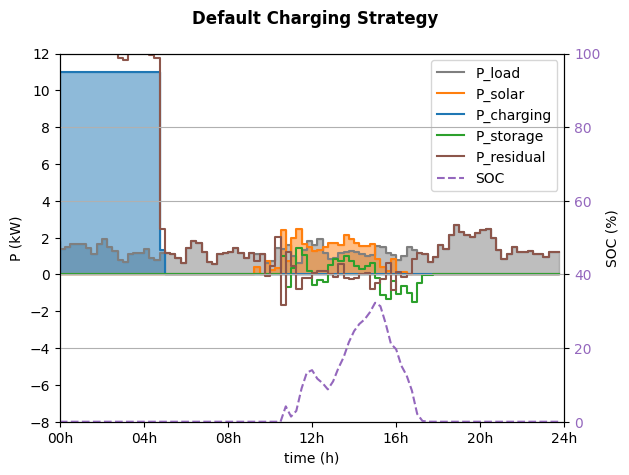

In [23]:
fig, ax1 = plt.subplots()

tag = 3

t1 = tag*96
t2 = (tag+1)*96


#plt.rcParams['axes.grid'] = True

# NUMBER Household
i = 0


#plt.grid()

# Time
t = np.arange(0,96)

# Axis Labels
ax1.set_xlabel("time (h)")
ax1.set_ylabel("P (kW)")

# Household Load
color = "tab:grey"
ax1.plot(t, results["household_"+str(i)]["P"][t1:t2], color = color, drawstyle = "steps", label = "P_load") 
ax1.tick_params(axis='y')
ax1.fill_between(t, results["household_"+str(i)]["P"][t1:t2], color = color, alpha=.5, step="pre")

# PV
color = "tab:orange"
ax1.plot(t, results["PV_"+str(i)]["P"][t1:t2], color = color, drawstyle = "steps", label = "P_solar")
ax1.fill_between(t, results["PV_"+str(i)]["P"][t1:t2], color = color, alpha=.5, step="pre")

# CS
color = "tab:blue"
ax1.plot(t, results["charging_station_"+str(i)]["P"][t1:t2], color = color, drawstyle = "steps", label = "P_charging")
ax1.fill_between(t, results["charging_station_"+str(i)]["P"][t1:t2], color = color, alpha=.5, step="pre")

# eStorage
color = "tab:green"
ax1.plot(t, results["eStorage_"+str(i)]["P"][t1:t2], color=color, drawstyle = "steps", label ="P_storage")

# Residual
color = "tab:brown"
ax1.plot(t,results["household_"+str(i)]["P_residual"][t1:t2], color = color, drawstyle = "steps", label = "P_residual")

## SOC
ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
color = "tab:purple"
ax2.plot(t, results["eStorage_0"]["SOC"][t1:t2], '--', color=color, label="SOC")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("SOC (%)")

## PLOT STYLE
# Legends
lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, [l.get_label() for l in lines], loc="best") #.get_frame().set_facecolor('C0') 

# PLOT LABEL
fig.subplots_adjust()
plot_label = "Default Charging Strategy"
fig.suptitle(plot_label, fontsize = 12, weight = "bold")

# Modifying x-axis
fig.canvas.draw() #We need to draw the canvas, otherwise the labels won't be positioned and won't have values yet.
# get default x_ticks
x_labels = [item.get_text() for item in ax1.get_xticklabels()]
# Setting x-ticks
ticks = np.arange(min(t),max(t+2),16)
ax1.set_xticks(ticks, minor = False) # every twelth value are 3 hours

# Setting y_ticks
ticks_y = np.arange(-8,14,2)
ax1.set_yticks(ticks_y, minor = False)

# Limit of x-axis 
ax1.set_xlim(0,96) #Wert 96 nicht verfügbar
set_x_labels = ["00h", "04h", "08h", "12h", "16h", "20h", "24h"]
ax1.set_xticklabels(set_x_labels)

# Limit of y-achis
ax2.set_ylim(0,100)
ax1.set_ylim(-8,12)

# GRID
ax1.grid() #turn ax1 grid off
ax2.grid() #turn ax2 grid off
ax1.grid(which='major') #only activates ax1 and drawas at major ticks

# Show plot
fig.tight_layout() # otherwise the right y-label is slightly clipped
#plt.show()
plt.savefig('P_Max', dpi=400)

## Forecast

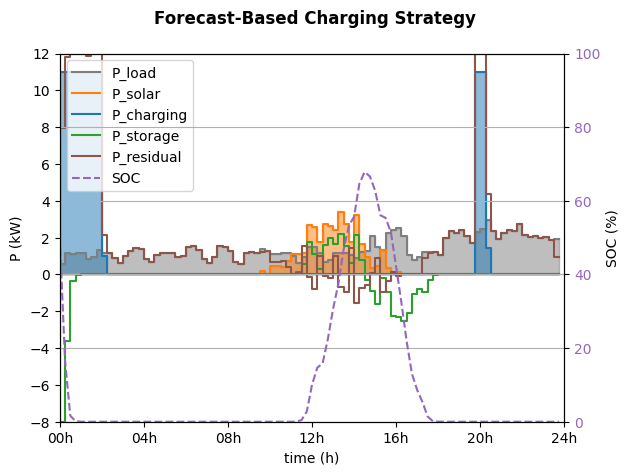

In [15]:
# PICKLE: data\database\results\results_2022-09-07_#4_prognosis.hdf5

fig, ax1 = plt.subplots()

tag = 0

t1 = tag*96
t2 = (tag+1)*96


#plt.rcParams['axes.grid'] = True

# NUMBER Household
i = 0


#plt.grid()

# Time
t = np.arange(0,96)

# Axis Labels
ax1.set_xlabel("time (h)")
ax1.set_ylabel("P (kW)")

# Household Load
color = "tab:grey"
ax1.plot(t, results["household_"+str(i)]["P"][t1:t2], color = color, drawstyle = "steps", label = "P_load") 
ax1.tick_params(axis='y')
ax1.fill_between(t, results["household_"+str(i)]["P"][t1:t2], color = color, alpha=.5, step="pre")

# PV
color = "tab:orange"
ax1.plot(t, results["PV_"+str(i)]["P"][t1:t2], color = color, drawstyle = "steps", label = "P_solar")
ax1.fill_between(t, results["PV_"+str(i)]["P"][t1:t2], color = color, alpha=.5, step="pre")

# CS
color = "tab:blue"
ax1.plot(t, results["charging_station_"+str(i)]["P"][t1:t2], color = color, drawstyle = "steps", label = "P_charging")
ax1.fill_between(t, results["charging_station_"+str(i)]["P"][t1:t2], color = color, alpha=.5, step="pre")

# eStorage
color = "tab:green"
ax1.plot(t, results["eStorage_"+str(i)]["P"][t1:t2], color=color, drawstyle = "steps", label ="P_storage")

# Residual
color = "tab:brown"
ax1.plot(t,results["household_"+str(i)]["P_residual"][t1:t2], color = color, drawstyle = "steps", label = "P_residual")

## SOC
ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
color = "tab:purple"
ax2.plot(t, results["eStorage_0"]["SOC"][t1:t2], '--', color=color, label="SOC")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("SOC (%)")

## PLOT STYLE
# Legends
lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, [l.get_label() for l in lines], loc=2) #.get_frame().set_facecolor('C0') 

# PLOT LABEL
fig.subplots_adjust()
plot_label = "Forecast-Based Charging Strategy"
fig.suptitle(plot_label, fontsize = 12, weight = "bold")

# Modifying x-axis
fig.canvas.draw() #We need to draw the canvas, otherwise the labels won't be positioned and won't have values yet.
# get default x_ticks
x_labels = [item.get_text() for item in ax1.get_xticklabels()]
# Setting x-ticks
ticks = np.arange(min(t),max(t+2),16)
ax1.set_xticks(ticks, minor = False) # every twelth value are 3 hours

# Setting y-ticks
ticks_y = np.arange(-8,14,2)
ax1.set_yticks(ticks_y, minor = False)

# Limit of x-axis 
ax1.set_xlim(0,96) #Wert 96 nicht verfügbar
set_x_labels = ["00h", "04h", "08h", "12h", "16h", "20h", "24h"]
ax1.set_xticklabels(set_x_labels)

# Limit of y-achis
ax2.set_ylim(0,100)
ax1.set_ylim(-8,12)

# GRID
ax1.grid() #turn ax1 grid off
ax2.grid() #turn ax2 grid off
ax1.grid(which='major') #only activates ax1 and drawas at major ticks

# Show plot
fig.tight_layout() # otherwise the right y-label is slightly clipped
#plt.show()
plt.savefig('Forecast', dpi=600)

## solar_charging

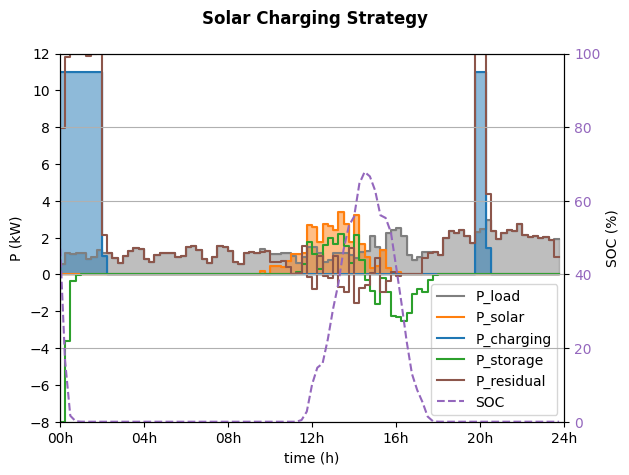

In [16]:
# PICKLE NO 42

fig, ax1 = plt.subplots()

tag = 0 #3

t1 = tag*96
t2 = (tag+1)*96


#plt.rcParams['axes.grid'] = True

# NUMBER Household
i = 0


#plt.grid()

# Time
t = np.arange(0,96)

# Axis Labels
ax1.set_xlabel("time (h)")
ax1.set_ylabel("P (kW)")

# Household Load
color = "tab:grey"
ax1.plot(t, results["household_"+str(i)]["P"][t1:t2], color = color, drawstyle = "steps", label = "P_load") 
ax1.tick_params(axis='y')
ax1.fill_between(t, results["household_"+str(i)]["P"][t1:t2], color = color, alpha=.5, step="pre")

# PV
color = "tab:orange"
ax1.plot(t, results["PV_"+str(i)]["P"][t1:t2], color = color, drawstyle = "steps", label = "P_solar")
ax1.fill_between(t, results["PV_"+str(i)]["P"][t1:t2], color = color, alpha=.5, step="pre")

# CS
color = "tab:blue"
ax1.plot(t, results["charging_station_"+str(i)]["P"][t1:t2], color = color, drawstyle = "steps", label = "P_charging")
ax1.fill_between(t, results["charging_station_"+str(i)]["P"][t1:t2], color = color, alpha=.5, step="pre")

# eStorage
color = "tab:green"
ax1.plot(t, results["eStorage_"+str(i)]["P"][t1:t2], color=color, drawstyle = "steps", label ="P_storage")

# Residual
color = "tab:brown"
ax1.plot(t,results["household_"+str(i)]["P_residual"][t1:t2], color = color, drawstyle = "steps", label = "P_residual")

## SOC
ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
color = "tab:purple"
ax2.plot(t, results["eStorage_0"]["SOC"][t1:t2], '--', color=color, label="SOC")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("SOC (%)")

## PLOT STYLE
# Legends
lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, [l.get_label() for l in lines], loc="best") #.get_frame().set_facecolor('C0') 

# PLOT LABEL
fig.subplots_adjust()
plot_label = "Solar Charging Strategy"
fig.suptitle(plot_label, fontsize = 12, weight = "bold")

# Modifying x-axis
fig.canvas.draw() #We need to draw the canvas, otherwise the labels won't be positioned and won't have values yet.
# get default x_ticks
x_labels = [item.get_text() for item in ax1.get_xticklabels()]
# Setting x-ticks
ticks = np.arange(min(t),max(t+2),16)
ax1.set_xticks(ticks, minor = False) # every twelth value are 3 hours
# Setting y_ticks
ticks_y = np.arange(-8,14,2)
ax1.set_yticks(ticks_y, minor = False)

# Limit of x-axis 
ax1.set_xlim(0,96) #Wert 96 nicht verfügbar
set_x_labels = ["00h", "04h", "08h", "12h", "16h", "20h", "24h"]
ax1.set_xticklabels(set_x_labels)

# Limit of y-achis
ax2.set_ylim(0,100)
ax1.set_ylim(-8,12)

# GRID
ax1.grid() #turn ax1 grid off
ax2.grid() #turn ax2 grid off
ax1.grid(which='major') #only activates ax1 and drawas at major ticks

# Show plot
fig.tight_layout() # otherwise the right y-label is slightly clipped
#plt.show()
plt.savefig('Solar', dpi=400)

## NIGHT CHARGING

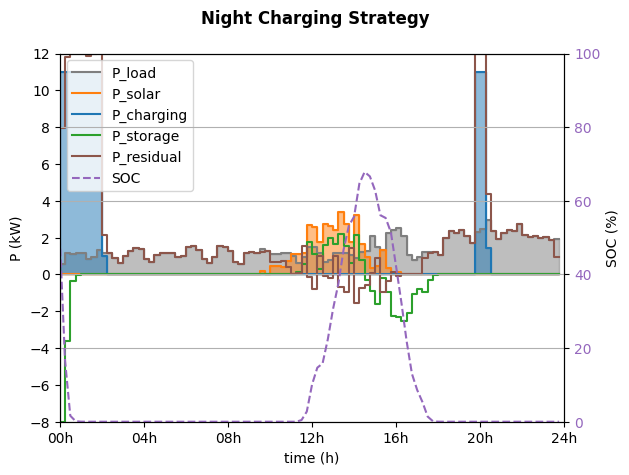

In [18]:
# PICKLE NO 44

fig, ax1 = plt.subplots()

tag = 0

t1 = tag*96
t2 = (tag+1)*96


#plt.rcParams['axes.grid'] = True

# NUMBER Household
i = 0

#plt.grid()

# Time
t = np.arange(0,96)

# Axis Labels
ax1.set_xlabel("time (h)")
ax1.set_ylabel("P (kW)")

# Household Load
color = "tab:grey"
ax1.plot(t, results["household_"+str(i)]["P"][t1:t2], color = color, drawstyle = "steps", label = "P_load") 
ax1.tick_params(axis='y')
ax1.fill_between(t, results["household_"+str(i)]["P"][t1:t2], color = color, alpha=.5, step="pre")

# PV
color = "tab:orange"
ax1.plot(t, results["PV_"+str(i)]["P"][t1:t2], color = color, drawstyle = "steps", label = "P_solar")
ax1.fill_between(t, results["PV_"+str(i)]["P"][t1:t2], color = color, alpha=.5, step="pre")

# CS
color = "tab:blue"
ax1.plot(t, results["charging_station_"+str(i)]["P"][t1:t2], color = color, drawstyle = "steps", label = "P_charging")
ax1.fill_between(t, results["charging_station_"+str(i)]["P"][t1:t2], color = color, alpha=.5, step="pre")

# eStorage
color = "tab:green"
ax1.plot(t, results["eStorage_"+str(i)]["P"][t1:t2], color=color, drawstyle = "steps", label ="P_storage")

# Residual
color = "tab:brown"
ax1.plot(t,results["household_"+str(i)]["P_residual"][t1:t2], color = color, drawstyle = "steps", label = "P_residual")

## SOC
ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
color = "tab:purple"
ax2.plot(t, results["eStorage_0"]["SOC"][t1:t2], '--', color=color, label="SOC")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("SOC (%)")

## PLOT STYLE
# Legends
lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, [l.get_label() for l in lines], loc=2) #.get_frame().set_facecolor('C0') 

# PLOT LABEL
fig.subplots_adjust()
plot_label = "Night Charging Strategy"
fig.suptitle(plot_label, fontsize = 12, weight = "bold")

# Modifying x-axis
fig.canvas.draw() #We need to draw the canvas, otherwise the labels won't be positioned and won't have values yet.
# get default x_ticks
x_labels = [item.get_text() for item in ax1.get_xticklabels()]
# Setting x-ticks
ticks = np.arange(min(t),max(t+2),16)
ax1.set_xticks(ticks, minor = False) # every twelth value are 3 hours

# Setting y_ticks
ticks_y = np.arange(-8,14,2)
ax1.set_yticks(ticks_y, minor = False)

# Limit of x-axis 
ax1.set_xlim(0,96) #Wert 96 nicht verfügbar
set_x_labels = ["00h", "04h", "08h", "12h", "16h", "20h", "24h"]
ax1.set_xticklabels(set_x_labels)

# Limit of y-achis
ax2.set_ylim(0,100)
ax1.set_ylim(-8,12)

# GRID
ax1.grid() #turn ax1 grid off
ax2.grid() #turn ax2 grid off
ax1.grid(which='major') #only activates ax1 and drawas at major ticks

# Show plot
fig.tight_layout() # otherwise the right y-label is slightly clipped
#plt.show()
plt.savefig('Night', dpi=400)

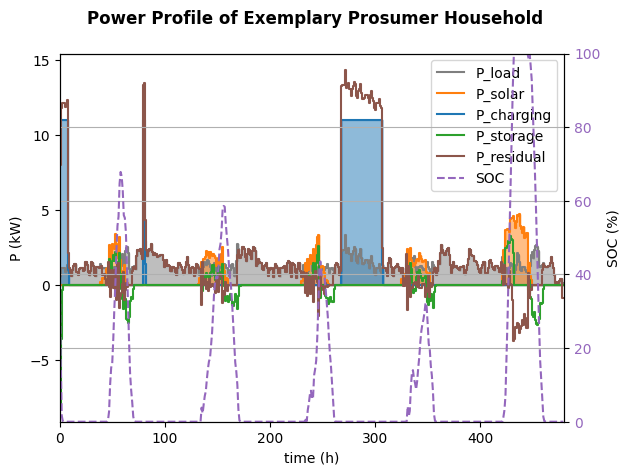

In [24]:
# WHOLE WEEK

fig, ax1 = plt.subplots()

tage = 5

t1 = 0
t2 = tage*96


#plt.rcParams['axes.grid'] = True
for j in range(0,1):
    for i in range(0,1):
        
        #plt.grid()

        # Time
        t = np.arange(0,tage*96)

        # Axis Labels
        ax1.set_xlabel("time (h)")
        ax1.set_ylabel("P (kW)")

        # Household Load
        color = "tab:grey"
        ax1.plot(t, results["household_"+str(i)]["P"][t1:t2], color = color, drawstyle = "steps",label = "P_load") 
        ax1.tick_params(axis='y')
        ax1.fill_between(t, results["household_"+str(i)]["P"][t1:t2], color = color, alpha=.5, step="pre")

        # PV
        color = "tab:orange"
        ax1.plot(t, results["PV_"+str(i)]["P"][t1:t2], color = color, drawstyle = "steps", label = "P_solar")
        ax1.fill_between(t, results["PV_"+str(i)]["P"][t1:t2], color = color, alpha=.5, step="pre")

        # CS
        color = "tab:blue"
        ax1.plot(t, results["charging_station_"+str(j)]["P"][t1:t2], color = color, drawstyle = "steps", label = "P_charging")
        ax1.fill_between(t, results["charging_station_"+str(j)]["P"][t1:t2], color = color, alpha=.5, step="pre")

        # eStorage
        color = "tab:green"
        ax1.plot(t, results["eStorage_0"]["P"][t1:t2], color=color, drawstyle = "steps", label ="P_storage")

        # Residual
        color = "tab:brown"
        ax1.plot(t,results["household_"+str(i)]["P_residual"][t1:t2], color = color, drawstyle = "steps", label = "P_residual")

        ## SOC
        ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
        color = "tab:purple"
        ax2.plot(t, results["eStorage_0"]["SOC"][t1:t2], '--', color=color, label="SOC")
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_ylabel("SOC (%)")

        ## PLOT STYLE
        # Legends
        lines = ax1.get_lines() + ax2.get_lines()
        ax1.legend(lines, [l.get_label() for l in lines], loc="best") #.get_frame().set_facecolor('C0') 

        # PLOT LABEL
        fig.subplots_adjust()
        plot_label = "Power Profile of Exemplary Prosumer Household"
        fig.suptitle(plot_label, fontsize = 12, weight = "bold")

        # Modifying x-axis
        fig.canvas.draw() #We need to draw the canvas, otherwise the labels won't be positioned and won't have values yet.
        # get default x_ticks
        #x_labels = [item.get_text() for item in ax1.get_xticklabels()]
        # Setting x-ticks
        #ticks = np.arange(min(t),max(t+2),16)
        #ax1.set_xticks(ticks, minor = False) # every twelth value are 3 hours
        # Limit of x-axis 
        ax1.set_xlim(0,tage*96) #Wert 96 nicht verfügbar
        #set_x_labels = ["00h", "04h", "08h", "12h", "16h", "20h", "24h"]
        #ax1.set_xticklabels(set_x_labels)

        # Limit of y-achis
        ax2.set_ylim(0,100)

        # GRID
        ax1.grid() #turn ax1 grid off
        ax2.grid() #turn ax2 grid off
        ax1.grid(which='major') #only activates ax1 and drawas at major ticks

# Show plot
fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.savefig("test")

In [ ]:
'''
TODO:
- Bug Fix Plot?
- Add name of charging_strategy to hdf5
- Update car.py so that initial_start date is read-in from .pickle file
- Simulate 3 days and plot third day. Best within week of Fernando

'''

In [19]:
## OLD PLOTS
def utils(datafilePath):
    #Reads the data stored in a hdf5 datafile
    data = h5py.File(datafilePath, "r")
    # Reading names of tracked components also known as series groups
    series = {}
    series["pv"] = [b for b in data["Series"].keys() if "PV" in b]
    series["load"] = [l for l in data["Series"].keys() if "Load" in l]
    series["storage"] = [s for s in data["Series"].keys() if "Storage" in s]
    series["cs"] = [c for c in data["Series"].keys() if "CS" in c]
    #print(series)
    # Reading tracked parameters of components
    series_parameters={}

    for component in data["Series"]:
        if "PV" in component:
            series_parameters["pv"] = [b for b in data["Series"][component].keys()]
        elif "Load" in component:
            series_parameters["load"] = [b for b in data["Series"][component].keys()]
        elif "Storage" in component:
            series_parameters["storage"] = [b for b in data["Series"][component].keys()]
        elif "Car" in component:
            series_parameters["car"] = [b for b in data["Series"][component].keys()]
        elif "CS" in component:
            series_parameters["cs"] = [b for b in data["Series"][component].keys()]

    #print(series_parameters)
    # Reading parameters or value definition of wanted datarow
    # params = {}
    # params["pv"] = ["P_ACTUAL"]
    # params["load"] = ["P"]
    # params["storage"] = ["SOC", "P_SET"]
    # params["cs"] = ["P"]
    #print(params)
    # WARNING FOR MORE THAN ONE COMPONENT IN A COMPONENT_GROUP ONE LAYER HAS TO BE ADDED (eg two PV) (level of nested dict +1)
    # create needed lists and (nested) dicts for results
    output_list = []
    results = {}
    for component_group, component_name in series.items():
        for component in component_name:
            #creates nested dict with modified columns (e.g. PVSim-0.PV_0 -> PV_0) as key
            results[component.split(".")[-1]] = {}

    # loop through all series.iterable (e.g. "pv") and components (e.g. "PVSim-0.PV_0")
    for component_group, component_name in series.items():
        # create new params (e.g. pv, car) list to loop
        params_list = series_parameters[component_group]
        for par in params_list:
                for component in component_name:
                    # save current time_series (e.g. ["pv"]["P_ACTUAL"])
                    output = data["Series"][component][par]
                    output_list.append(output)                       
                    
                    # factor for converting [W] into [kW] and [-] into [%]
                    if component_group in ["cs", "load", "storage", "pv"]:
                        factor = 1/1000
                    if par in ["SOC"]:
                        factor = 100 
                    
                    #fill dict (e.g. PV_0) with each params
                    results[component.split(".")[-1]][par] = np.array(output)*factor
    #print(results.keys())
    no_households = len(series['load'])
    no_of_cs = len(series['cs'])
    # Residuallast
    for i in range(0,no_households):
        results["household_"+str(i)]["P_residual"] = results["household_"+str(i)]["P"] - abs(results["PV_"+str(i)]["P"]) 
    # Show what is available
    print("Die folgenden Komponenten stehen zur Verfügung: ",results.keys())
    print()
    print("Die folgenden Parameter wurden überwacht: ",series_parameters)
    return results, series_parameters

def plot(results, no_households=1, no_of_cs=1):
    fig, ax1 = plt.subplots(2,2, figsize=(20, 20))
    m=0
    n=0
    for k in range(len(results)):
        for j in range(0,no_of_cs):
            for i in range(0,no_households):
                
                plt.grid()

                # Time
                t = np.arange(0,96)

                # Axis Labels
                ax1[m][n].set_xlabel("time (h)")
                ax1[m][n].set_ylabel("P (kW)")

                # Household Load
                color = "tab:grey"
                ax1[m][n].plot(t, results[k]["household_"+str(i)]["P"], color = color, drawstyle = "steps") 
                ax1[m][n].tick_params(axis='y')
                ax1[m][n].fill_between(t, results[k]["household_"+str(i)]["P"], color = color, alpha=.5, step="pre")

                # PV
                color = "tab:orange"
                ax1[m][n].plot(t, results[k]["PV_"+str(i)]["P"], color = color, drawstyle = "steps", label = "P_solar")
                ax1[m][n].fill_between(t, results[k]["PV_"+str(i)]["P"], color = color, alpha=.5, step="pre")

                # CS
                color = "tab:blue"
                ax1[m][n].plot(t, results[k]["charging_station_"+str(j)]["P"], color = color, drawstyle = "steps", label = "P_charging")
                ax1[m][n].fill_between(t, results[k]["charging_station_"+str(j)]["P"], color = color, alpha=.5, step="pre")

                # eStorage
                color = "tab:green"
                ax1[m][n].plot(t, results[k]["eStorage_0"]["P"], color=color, drawstyle = "steps", label ="P_storage")

                # Residual
                color = "tab:brown"
                ax1[m][n].plot(t,results[k]["household_"+str(i)]["P_residual"], color = color, drawstyle = "steps", label = "P_residual")

                ## SOC
                ax2 = ax1[m][n].twinx() # instantiate a second axes that shares the same x-axis
                color = "tab:purple"
                ax2.plot(t, results[k]["eStorage_0"]["SOC"], '--', color=color, label="SOC")
                ax2.tick_params(axis='y', labelcolor=color)
                ax2.set_ylabel("SOC (%)")

                ## PLOT STYLE
                # Legends
                lines = ax1[m][n].get_lines() + ax2.get_lines()
                ax1[m][n].legend(lines, [l.get_label() for l in lines], loc="best") #.get_frame().set_facecolor('C0') 

                # PLOT LABEL
                fig.subplots_adjust()
                plot_label = "Power Profile of Exemplary Prosumer Household"
                fig.suptitle(plot_label, fontsize = 12, weight = "bold")

                # Modifying x-axis
                fig.canvas.draw() #We need to draw the canvas, otherwise the labels won't be positioned and won't have values yet.
                # get default x_ticks
                x_labels = [item.get_text() for item in ax1[m][n].get_xticklabels()]
                # Setting x-ticks
                ticks = np.arange(min(t),max(t+2),16)
                ax1[m][n].set_xticks(ticks, minor = False) # every twelth value are 3 hours
                # Limit of x-axis 
                ax1[m][n].set_xlim(0,96) #Wert 96 nicht verfügbar
                set_x_labels = ["00h", "04h", "08h", "12h", "16h", "20h", "24h"]
                ax1[m][n].set_xticklabels(set_x_labels)

                n = n+1

                if n == 2 and m<2:
                    m=m+1
                    n=0

    # Show plot
    fig.tight_layout() # otherwise the right y-label is slightly clipped
    plt.show()